In [1]:
# read data: 30 ICs 
import nipype.interfaces.io as nio
import os
PD_ICA_file='/templateflow/PD_ICAs';
ICs_list=list(range(30))
ICs_list=["{:0>4d}".format(x) for x in ICs_list]
# file import
ds_ic = nio.DataGrabber(infields=['IC_id'])
ds_ic.inputs.base_directory = PD_ICA_file # database
ds_ic.inputs.template = 'melodic_IC_%4s.nii.gz' # from cwd
ds_ic.inputs.sort_filelist = True
ds_ic.inputs.IC_id = ICs_list
res_ic = ds_ic.run()
ic_list=res_ic.outputs.outfiles
# read local ic
PD_ICA_local_file='/output/PD_ICA/ICA_local/stats';
ICs_local_list=[x+1 for x in list(range(19))]
#ICs_local_list=["{:0>4d}".format(x) for x in ICs_local_list]
# file import
ds_local_ic = nio.DataGrabber(infields=['IC_id'])
ds_local_ic.inputs.base_directory = PD_ICA_local_file # database
ds_local_ic.inputs.template = 'thresh_zstat%s.nii.gz' # from cwd
ds_local_ic.inputs.sort_filelist = True
ds_local_ic.inputs.IC_id = ICs_local_list
res_local_ic = ds_local_ic.run()
ic_local_list=res_local_ic.outputs.outfiles
#print(ic_local_list)
# read data: 3 study groups by sub_list 
GROUPS=['PD','ET','NC']
OUT_DIR='/output/PD_ICA/'
SUB_LIST=[]; AGE_LIST=[]; JCOB_LIST=[];
print('Local data: ')
for group_name in GROUPS:
    current_group=group_name
    current_sub_list_file = '/codes/devel/PD_Marker/'+current_group+'_info_ICA.list'
    # create dir for output
    current_OUT_DIR=OUT_DIR+current_group+'/'
    if not os.path.exists(current_OUT_DIR):
        os.makedirs(current_OUT_DIR)
    #read sub list
    with open(current_sub_list_file, 'r') as f_sub:
        sub_list_raw= f_sub.readlines()
    sub_list = [x[0:-1].split('\t')[0] for x in sub_list_raw] # remove 
    age_list = [int(x[0:-1].split('\t')[1]) for x in sub_list_raw]
    SUB_LIST.append(sub_list);  AGE_LIST.append(age_list);
    N_sub=len(sub_list)
    print(group_name, ': ', N_sub)
    # grab group Jacobians
    ds_jacobian = nio.DataGrabber(infields=['sub_id'])
    ds_jacobian.inputs.base_directory = current_OUT_DIR # database
    ds_jacobian.inputs.template = '%s_desc-preproc_T1w_space-MNI2009c_Warp_Jacobian.nii.gz' # from cwd
    ds_jacobian.inputs.sort_filelist = True
    ds_jacobian.inputs.sub_id = sub_list
    res_jacobian = ds_jacobian.run()
    jacobian_list=res_jacobian.outputs.outfiles
    JCOB_LIST.append(jacobian_list)
pd_sub_list = SUB_LIST[0]; et_sub_list = SUB_LIST[1]; nc_sub_list = SUB_LIST[2]; 
pd_age_list = AGE_LIST[0]; et_age_list = AGE_LIST[1]; nc_age_list = AGE_LIST[2];
pd_jaco_list=JCOB_LIST[0]; et_jaco_list=JCOB_LIST[1]; nc_jaco_list=JCOB_LIST[2];
# read all the AD-subjects
import pandas as pd
sub_list_file = '/output/PPMI_DBM_AD/subject_IDs.csv'
ad_sub_list_df=pd.read_csv(sub_list_file, sep=',', header=0, index_col=0)
ad_sub_label= ['PD' if x==1 else 'NC' for x in list(ad_sub_list_df['PD'])]
N_ad_sub=len(ad_sub_label); N_ad_PD=sum(list(ad_sub_list_df['PD'])); N_ad_NC=N_ad_sub-N_ad_PD;
ad_sub_list = [str(x) for x in list(range(N_ad_sub))]
ad_jacobian_dir='/output/PPMI_DBM_AD/sub_dbm/'
ad_jacobian = nio.DataGrabber(infields=['sub_id'])
ad_jacobian.inputs.base_directory = ad_jacobian_dir # database
ad_jacobian.inputs.template = 'sub-%s_dbm.nii.gz' # from cwd
ad_jacobian.inputs.sort_filelist = True
ad_jacobian.inputs.sub_id = ad_sub_list
res_ad_jacobian = ad_jacobian.run()
ad_jacobian_list=res_ad_jacobian.outputs.outfiles
print('AD data: \nPD : ', N_ad_PD, '\nNC : ', N_ad_NC)

201001-03:23:31,899 nipype.utils WARNING:
	 A newer version (1.5.1) of nipy/nipype is available. You are using 1.5.0
Local data: 
PD :  40
ET :  29
NC :  33
AD data: 
PD :  232 
NC :  117


In [2]:
# PCA of local data (need to check)
from nilearn.decomposition import multi_pca
ICA_AB_PATH ='/output/PD_ICA/'
AB_merged_file = ICA_AB_PATH+'ICA_locallocal_pd+nc_4d.nii.gz'
ab_pca_model= multi_pca.MultiPCA(n_components=20, do_cca=True, n_jobs=-1)
ab_pca_model_fit=ab_pca_model.fit(AB_merged_file)
# PCA of AD data
ICA_AD_PATH ='/output/PPMI_DBM_AD/'
AD_merged_file = ICA_AD_PATH+'reshape_merged_dbm3_masked.nii'
from nilearn.decomposition import multi_pca
ad_pca_model= multi_pca.MultiPCA(n_components=30, do_cca=True, n_jobs=-1)
ad_pca_model_fit=ad_pca_model.fit(AD_merged_file)

In [70]:
# read corr data and function init
import numpy as np
ad_ad_corr_file='ad_all-ic_mean-corr.csv'; ad_ab_corr_file='ab_all-ic_mean-corr.csv'
ab_ad_corr_file='abxad-ic_mean-corr.csv';  ab_ab_corr_file='abxab-ic_mean-corr.csv'
ad_ad_corr = pd.read_csv(ad_ad_corr_file, sep=',', header=0, index_col=0)
ad_ab_corr = pd.read_csv(ad_ab_corr_file, sep=',', header=0, index_col=0)
ab_ad_corr = pd.read_csv(ab_ad_corr_file, sep=',', header=0, index_col=0)
ab_ab_corr = pd.read_csv(ab_ab_corr_file, sep=',', header=0, index_col=0)

N_ad_ic = len(ic_list); N_ab_ic = len(ic_local_list);
N_ab_PD = len(pd_sub_list); N_ab_ET = len(et_sub_list); 
N_ab_NC = len(nc_sub_list);
N_ad_PD = sum(list(ad_ad_corr.PD)); N_ad_NC = len(ad_ad_corr)-N_ad_PD
# PPMI-IC in local PD/NC   
ad_ab_corr_PD=pd.concat([ad_ab_corr[ad_ab_corr.PD==1], ad_ab_corr[ad_ab_corr.PD==0]])
# local-IC in local PD/NC 
ab_ab_corr_PD=pd.concat([ab_ab_corr[ab_ab_corr.PD==1], ab_ab_corr[ab_ab_corr.PD==0]])
# PPMI-IC in local ET/NC   
ad_ab_corr_ET=pd.concat([ad_ab_corr[ad_ab_corr.PD==-1], ad_ab_corr[ad_ab_corr.PD==0]])
ad_ab_corr_ET.PD=np.square(list(ad_ab_corr_ET.PD))
# local-IC in local ET/NC 
ab_ab_corr_ET=pd.concat([ab_ab_corr[ab_ab_corr.PD==-1], ab_ab_corr[ab_ab_corr.PD==0]])
ab_ab_corr_ET.PD=np.square(list(ab_ab_corr_ET.PD))
#ad_PD_index = 
def cv_score(X, N_ic, N_cv):
    from sklearn import svm
    from sklearn.model_selection import cross_val_score
    m_list=[]; v_list=[];
    for i_ic in range(1,N_ic+1):
        x_mat=X.iloc[:,0:i_ic]; y=X['PD'];
        clf = svm.SVC(kernel='sigmoid', C=1)
        scores = cross_val_score(clf, x_mat, y, cv=N_cv)
        m_list.append(scores.mean())
        v_list.append(scores.std())
    return m_list, v_list
N_cv=10

0.6100840336134453 0.7


Text(0.5, 0, 'PPMI ICs (30)')

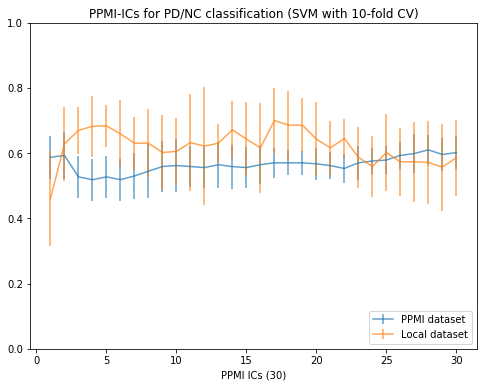

In [113]:
# AD-IC ic in PD/NC in both datasets
import matplotlib.pyplot as plt
ad_mean, ad_var = cv_score(ad_ad_corr, N_ad_ic, N_cv)
ab_mean, ab_var = cv_score(ad_ab_corr_PD, N_ad_ic, N_cv)
x = list(range(1, N_ad_ic+1))
print(max(ad_mean), max(ab_mean))
fig = plt.figure(figsize=[8, 6])
plt.errorbar(x, ad_mean, yerr=ad_var, alpha=.7, label='PPMI dataset')
plt.errorbar(x, ab_mean, yerr=ab_var, alpha=.7, label='Local dataset')
plt.legend(loc='lower right')
plt.title('PPMI-ICs for PD/NC classification (SVM with 10-fold CV)')
plt.ylim(0, 1)
plt.xlabel('PPMI ICs (30)')

0.6045378151260504 0.6589285714285713


Text(0.5, 0, 'Local ICs (19)')

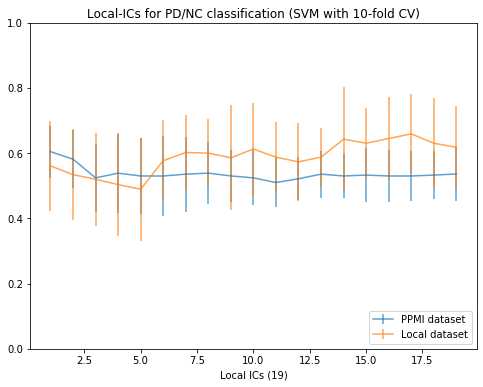

In [114]:
# Local-IC ic in PD/NC in both datasets
import matplotlib.pyplot as plt
ad_mean, ad_var = cv_score(ab_ad_corr, N_ab_ic, N_cv)
ab_mean, ab_var = cv_score(ab_ab_corr_PD, N_ab_ic, N_cv)
x = list(range(1, N_ab_ic+1))
print(max(ad_mean), max(ab_mean))
fig = plt.figure(figsize=[8, 6])
plt.errorbar(x, ad_mean, yerr=ad_var, alpha=.7, label='PPMI dataset')
plt.errorbar(x, ab_mean, yerr=ab_var, alpha=.7, label='Local dataset')
plt.legend(loc='lower right')
plt.title('Local-ICs for PD/NC classification (SVM with 10-fold CV)')
plt.ylim(0, 1)
plt.xlabel('Local ICs (19)')

0.7 0.7285714285714285


Text(0.5, 0, 'PPMI 30 ICs')

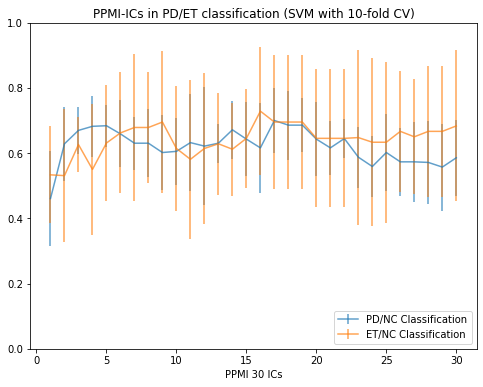

In [106]:
# AD-IC for ET/NC and PD/NC on 
import matplotlib.pyplot as plt
ad_mean, ad_var = cv_score(ad_ab_corr_PD, N_ad_ic, N_cv)
ab_mean, ab_var = cv_score(ad_ab_corr_ET, N_ad_ic, N_cv)
x = list(range(1, N_ic+1))
print(max(ad_mean), max(ab_mean))
fig = plt.figure(figsize=[8, 6])
plt.errorbar(x, ad_mean, yerr=ad_var, alpha=.7, label='PD/NC Classification')
plt.errorbar(x, ab_mean, yerr=ab_var, alpha=.7, label='ET/NC Classification')
plt.legend(loc='lower right')
plt.title('PPMI-ICs in PD/ET classification (SVM with 10-fold CV)')
plt.ylim(0, 1)
plt.xlabel('PPMI 30 ICs')

0.6589285714285713 0.6785714285714286


Text(0.5, 0, 'Local 19 ICs')

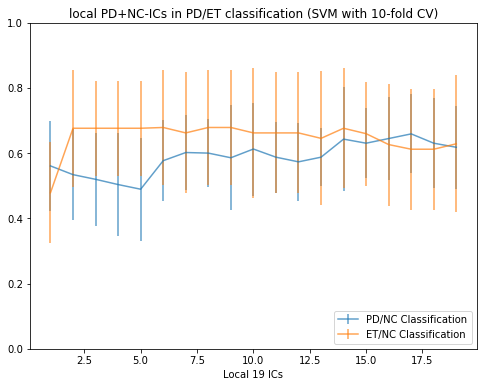

In [109]:
# local-IC for ET/NC and PD/NC on 
import matplotlib.pyplot as plt
ad_mean, ad_var = cv_score(ab_ab_corr_PD, N_ab_ic, N_cv)
ab_mean, ab_var = cv_score(ab_ab_corr_ET, N_ab_ic, N_cv)
print(max(ad_mean), max(ab_mean))
x = list(range(1, N_ab_ic+1))
fig = plt.figure(figsize=[8, 6])
plt.errorbar(x, ad_mean, yerr=ad_var, alpha=.7, label='PD/NC Classification')
plt.errorbar(x, ab_mean, yerr=ab_var, alpha=.7, label='ET/NC Classification')
plt.legend(loc='lower right')
plt.title('local PD+NC-ICs in PD/ET classification (SVM with 10-fold CV)')
plt.ylim(0, 1)
plt.xlabel('Local 19 ICs')

0.7285714285714285 0.6785714285714286


Text(0.5, 1.0, 'Local-ICs in ET/NC classification\n (10-fold CV SVM)')

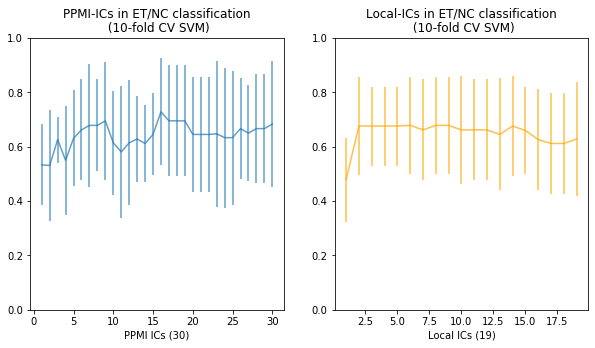

In [119]:
# AD-IC/local-IC for ET/NC
import matplotlib.pyplot as plt
ad_mean, ad_var = cv_score(ad_ab_corr_ET, N_ad_ic, N_cv)
ab_mean, ab_var = cv_score(ab_ab_corr_ET, N_ab_ic, N_cv)
print(max(ad_mean), max(ab_mean))
x  = list(range(1, N_ad_ic+1))
x1 = list(range(1, N_ab_ic+1))
#plt.figure(figsize=[8, 6])
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[10, 5])
axs.flat[0].errorbar(x, ad_mean, yerr=ad_var, alpha=.7,)
axs.flat[0].set_title('PPMI-ICs in ET/NC classification\n (10-fold CV SVM)')
axs.flat[0].set_ylim(0, 1); axs.flat[0].set_xlabel('PPMI ICs (30)')
axs.flat[1].errorbar(x1, ab_mean, yerr=ab_var, alpha=.7, c='orange')
axs.flat[1].set_ylim(0, 1); axs.flat[1].set_xlabel('Local ICs (19)')
axs.flat[1].set_title('Local-ICs in ET/NC classification\n (10-fold CV SVM)')

In [81]:
# test GLM model
import statsmodels.api as sm
import statsmodels.formula.api as smf

model1_str = 'PD ~ ic0 + ic1 + ic2 + ic3 + ic4 + ic5 + ic6 + ic7 + ic8 + ic9 + ic10 + ic11 + ic12 + ic13 + ic14 + ic15 + ic16 + ic17 + ic18 + ic19 + ic20 + ic21 + ic22  + ic23 + ic24 + ic25 + ic26 + ic27 + ic28 + ic29'
model2_str = 'PD ~ ic0 + ic1 + ic2 + ic3 + ic4 + ic5 + ic6 + ic7'

model1_fit = smf.glm(model1_str, ad_corr, family=sm.families.Binomial(link=sm.families.links.logit)).fit()
model2_fit = smf.glm(model2_str, ad_corr, family=sm.families.Binomial(link=sm.families.links.logit)).fit()
#print(model1_fit.summary())
#print(model2_fit.summary())
ab_corr.columns

/usr/local/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  if sys.path[0] == '':


Index(['ic0', 'ic1', 'ic2', 'ic3', 'ic4', 'ic5', 'ic6', 'ic7', 'ic8', 'ic9',
       'ic10', 'ic11', 'ic12', 'ic13', 'ic14', 'ic15', 'ic16', 'ic17', 'ic18',
       'ic19', 'ic20', 'ic21', 'ic22', 'ic23', 'ic24', 'ic25', 'ic26', 'ic27',
       'ic28', 'ic29', 'label', 'PD', 'ID'],
      dtype='object')

In [19]:
%matplotlib inline
# read MELODIC PCA
import nibabel as nib
tmp_img='/output/PPMI_DBM_AD/AD-ICA/melodic_pca.nii.gz'
tmp_img2='/output/PPMI_DBM_AD/AD-ICA/melodic_IC.nii.gz'
tmp_img1='/output/PD_ICA/ICA_local/melodic_pca.nii.gz'
tmp_img3='/output/PD_ICA/ICA_local/melodic_IC.nii.gz'
pca_melodic_ad=nib.load(tmp_img)
pca_melodic_ab=nib.load(tmp_img1)
ica_melodic_ad=nib.load(tmp_img2)
ica_melodic_ab=nib.load(tmp_img3)
print(pca_melodic_ab.shape, pca_melodic_ad.shape, ica_melodic_ad.shape,ica_melodic_ab.shape )

(193, 229, 193, 19) (101, 119, 97, 30) (101, 119, 97, 30) (193, 229, 193, 19)


In [ ]:
#vis for naive corr
import numpy as np
def plot_corrICA(a, b, c):
    al=np.zeros(len(a)); bl=np.zeros(len(b)); cl=np.zeros(len(c));
    x=list(range(al+bl+cl))
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title('Group element-wise correlation', color='C0')
    ax.plot(x[0:al-1], a,  label='PD: '+str(round(np.mean(a),4))+'~'+str(round(np.std(a),4)))
    ax.plot(x[al:al+bl-1],b ,  label='NC: '+str(round(np.mean(b),4))+'~'+str(round(np.std(b),4)))
    ax.plot(x[al+bl:al+bl+cl-1], c,  label='ET: '+str(round(np.mean(c),4))+'~'+str(round(np.std(c),4)))
    ax.legend()
plot_corrICA(pd_jaco_corr_list[], nc_jaco_corr_list[], et_jaco_corr_list[])